In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

import os

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
def open_images():
    """returns the images and labels of the images in the folder

    Returns:
        np array: images_arr
        np array: labels_arr
    """
    images_arr = []
    labels_arr = []
    counter = 0
    for class_name in os.listdir('./dinos_processed'):
        for image in os.listdir(f'./dinos_processed/{class_name}'):
            img = Image.open(f'./dinos_processed/{class_name}/{image}')
            img_gray = img.convert('L')  # convert image to grayscale
            images_arr.append(np.array(img_gray))
            labels_arr.append(class_name.lower())

        counter += 1

        if counter == 2:
            break # only two classes for now

    return np.array(images_arr), np.array(labels_arr)
    

x, y = open_images()
x.shape


(200, 100, 100)

Son 100 imagenes, de 100x100, en los 3 canales RGB.

In [4]:
np.unique(y)

array(['parasaurolophus', 'spinosaurus'], dtype='<U15')

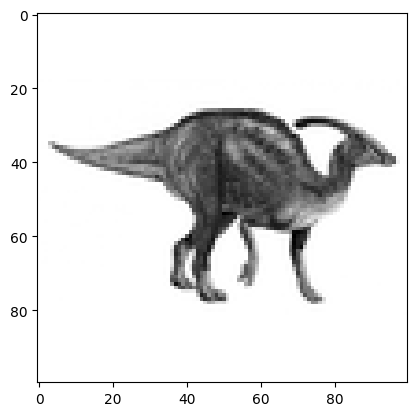

In [18]:
plt.imshow(x[10], cmap='gray')

In [6]:
# We split the data into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [8]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)
np.unique(train_labels)

array([0, 1])

In [9]:
num_classes = len(np.unique(y))
print("number of classes: ", num_classes)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)
train_labels

number of classes:  2


array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.

In [10]:
train_labels.shape
train_labels[0]

array([1., 0.])

## Modelo de Datos

In [11]:
base_filters = 32
w_regularizer = 1e-4

In [12]:
model = tf.keras.Sequential()

# First layer
model.add(Conv2D(filters=base_filters, kernel_size=(3,3), kernel_regularizer=regularizers.l2(w_regularizer), padding='same', activation='relu', input_shape=(100,100,1)))
model.add(Activation('relu'))

# Second layer
model.add(Conv2D(filters=2*base_filters, kernel_size=(3,3), kernel_regularizer=regularizers.l2(w_regularizer), padding='same', activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Third layer
model.add(Conv2D(filters=2*base_filters, kernel_size=(3,3), kernel_regularizer=regularizers.l2(w_regularizer), padding='same', activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Fourth layer
model.add(Conv2D(filters=2*base_filters, kernel_size=(3,3), kernel_regularizer=regularizers.l2(w_regularizer), padding='same', activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Fifth layer
model.add(Conv2D(filters=4*base_filters, kernel_size=(3,3), kernel_regularizer=regularizers.l2(w_regularizer), padding='same', activation='relu'))
model.add(Activation('relu'))

# Sixth layer
model.add(Conv2D(filters=4*base_filters, kernel_size=(3,3), kernel_regularizer=regularizers.l2(w_regularizer), padding='same', activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Flatten the output
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        36,866 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 350,978 (1.34 MB)

 Trainable params: 350,978 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [15]:
hist = model.fit(train_images, train_labels, batch_size=32, epochs=50, verbose=1, shuffle=True)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 764ms/step - accuracy: 0.9966 - loss: 0.0662
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 788ms/step - accuracy: 1.0000 - loss: 0.0567
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 828ms/step - accuracy: 0.9871 - loss: 0.0769
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 785ms/step - accuracy: 0.9945 - loss: 0.0587
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 868ms/step - accuracy: 0.8712 - loss: 0.7136
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9979 - loss: 0.0601
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9889 - loss: 0.0651
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 883ms/step - accuracy: 1.0000 - loss: 0.0437
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 841ms/step - accuracy: 1.0000 - loss: 0.0425
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 802ms/step - accuracy: 1.0000 - loss: 0.0397
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 898ms/step - accuracy: 1.0000 - loss: 0.0429
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 915ms/step - accuracy: 1.0000 - loss: 0.

In [16]:
# Assuming test_images and test_labels are your testing data and labels
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

2/2 - 0s - 242ms/step - accuracy: 0.7750 - loss: 1.6238

Test accuracy: 0.7749999761581421


## Save model 

In [21]:
# Save the model
model.save('out/cnn.keras')